This code will load the model information, generate the model definition, and run the model estimation using FSL

In [1]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting
sys.path.append('../utils/')
from compute_fd_dvars import compute_fd,compute_dvars

from make_event_files_from_json import MakeEventFilesFromJSON
%matplotlib inline
import matplotlib.pyplot as plt


try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'
    
results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print 'Using data from',datadir

Using data from /home/vagrant/data


Load the scan and model info, and generate the event files for FSL from the information in model.json

In [2]:
subject='sub00001'
session='ses014'  
# note - we have to use the anatomy from a different session'
subdir=os.path.join(datadir,'ds031', subject, session)
tasknum=2 # n-back

preprocessed_epi = os.path.join(results_dir, "preprocessed_epi_native_space.nii")

scaninfo=json.load(open(os.path.join(subdir,
        'functional/sub00001_ses014_task002_run001_bold.json')))
tr=scaninfo['RepetitionTime']

modelfile=os.path.join(subdir,'model.json')
modelinfo=json.load(open(modelfile))
taskinfo=modelinfo['task%03d'%tasknum]['model001']
evs=taskinfo['Variables']
contrasts=taskinfo['Contrasts']

# get the response onsets
response_onsets=[]

for v in evs.iterkeys():

    if evs[v]['VariableName'].find('_target_ons')>-1:
        for ons in evs[v]['onsets']:
            response_onsets.append(ons[0])

Load the motion parameters that we created during preprocessing, so we can use them as regressors.  Also generate the framewise displacement.

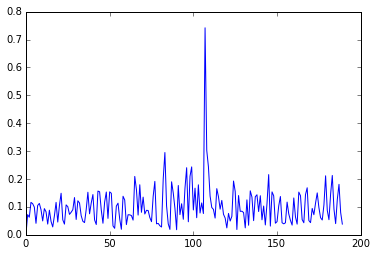

In [3]:
mcpars=numpy.loadtxt('/home/vagrant/fmri-analysis-vm/analysis/preprocessing/nipype_mem/nipype-interfaces-fsl-preprocess-MCFLIRT/a06d2fe43fd8d45183f86c7f607ad25c/sub00001_ses014_task002_run001_bold_mcf.nii.gz.par')

fd=compute_fd(mcpars)
plt.plot(fd)

Specify the model.  For the sake of speed we will use a simplified model that treats the study as a blocked design rather than modeling each item separately, but we also model instructions and motor responses; this, it is a hybrid block/event-related design

In [4]:
instruction_onsets=list(numpy.array([68,176,372,2,154,416,24,220,350,112,198,328,46,264,394,90,242,306])-2.0)

info = [Bunch(conditions=['faces-1back',
                          'faces-2back',
                          'scenes-1back',
                          'scenes-2back',
                          'chars-1back',
                          'chars-2back',
                          'instructions',
                          'responses'],
              onsets=[[68,176,372],
                      [2,154,416],
                      [24,220,350],
                      [112,198,328],
                      [46,264,394],
                      [90,242,306],
                      instruction_onsets,
                      response_onsets],
              durations=[[20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [20],
                         [2],
                         [1]],
            regressors=[fd],
            regressor_names=['FD'])
       ]

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = preprocessed_epi
s.inputs.time_repetition = tr
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()
s.inputs


event_files = <undefined>
functional_runs = ['/home/vagrant/fmri-analysis-vm/analysis/results/preprocessed_epi_native_space.nii']
high_pass_filter_cutoff = 128.0
ignore_exception = False
input_units = secs
outlier_files = <undefined>
realignment_parameters = <undefined>
subject_info = [Bunch(conditions=['faces-1back', 'faces-2back', 'scenes-1back', 'scenes-2back', 'chars-1back', 'chars-2back', 'instructions', 'responses'], durations=[[20], [20], [20], [20], [20], [20], [2], [1]], onsets=[[68, 176, 372], [2, 154, 416], [24, 220, 350], [112, 198, 328], [46, 264, 394], [90, 242, 306], [66.0, 174.0, 370.0, 0.0, 152.0, 414.0, 22.0, 218.0, 348.0, 110.0, 196.0, 326.0, 44.0, 262.0, 392.0, 88.0, 240.0, 304.0], [60.024, 62.024, 98.023, 270.027, 400.013, 14.021, 70.011, 74.013, 160.015, 170.019, 178.022, 186.025, 374.019, 384.024, 432.027, 34.013, 36.014, 122.016, 214.02, 334.02, 362.014]], regressor_names=['FD'], regressors=[array([ 0.        ,  0.07236592,  0.06300166,  0.11626191,  0.11167607

Generate the fsf and ev files using Level1Design

In [5]:
contrasts=[['faces>Baseline','T', 
            ['faces-1back','faces-2back'],[0.5,0.5]],
           ['scenes>Baseline','T', 
            ['scenes-1back','scenes-2back'],[0.5,0.5]],
           ['chars>Baseline','T', 
            ['chars-1back','chars-2back'],[0.5,0.5]],
           ['2back>1back','T', 
            ['faces-1back','faces-2back','scenes-1back','scenes-2back','chars-1back','chars-2back'],[-1,1,-1,1,-1,1,-1,1]],
          ['response>Baseline','T',
           ['responses'],[1]],
          ['instructions>Baseline','T',
           ['instructions'],[1]]]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = tr,
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

INFO:workflow:Executing node 52ff1f62c901f0b8440f5a4e4b19908f in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/52ff1f62c901f0b8440f5a4e4b19908f
INFO:workflow:Collecting precomputed outputs



ev_files = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/52ff1f62c901f0b8440f5a4e4b19908f/ev_faces-1back_0_1.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/52ff1f62c901f0b8440f5a4e4b19908f/ev_faces-2back_0_3.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/52ff1f62c901f0b8440f5a4e4b19908f/ev_scenes-1back_0_5.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/52ff1f62c901f0b8440f5a4e4b19908f/ev_scenes-2back_0_7.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/52ff1f62c901f0b8440f5a4e4b19908f/ev_chars-1back_0_9.txt', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-Level1Design/52ff1f62c901f0b8440f5a4e4b19908f/ev_chars-2back_0_11.txt', '/home/vagra

Generate the full set of model files using FEATModel

In [6]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

INFO:workflow:Executing node e5bf29c14815f881ae154dc134e7d254 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e5bf29c14815f881ae154dc134e7d254
INFO:workflow:Collecting precomputed outputs



con_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e5bf29c14815f881ae154dc134e7d254/run0.con
design_cov = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e5bf29c14815f881ae154dc134e7d254/run0_cov.png
design_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e5bf29c14815f881ae154dc134e7d254/run0.mat
design_image = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e5bf29c14815f881ae154dc134e7d254/run0.png
fcon_file = <undefined>

Visualize the design matrix

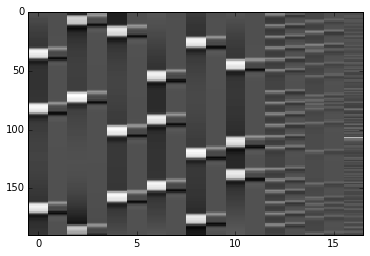

In [7]:
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

Show the correlation matrix for design

<matplotlib.colorbar.Colorbar instance at 0x7fc5743f6638>

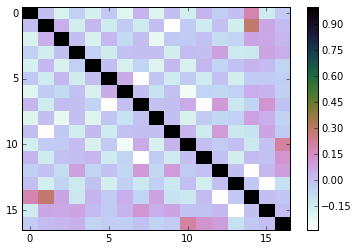

In [8]:
cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.cubehelix_r)
plt.colorbar()

Estimate the model using FILMGLS - this will take a few minutes.

In [9]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=preprocessed_epi,
                    mask_file=os.path.join(results_dir, "mask.nii.gz"))
mask_results.outputs

INFO:workflow:Executing node e81a246499f2e055440f9bb0f2cafc12 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/e81a246499f2e055440f9bb0f2cafc12
INFO:workflow:Collecting precomputed outputs



out_file = /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/e81a246499f2e055440f9bb0f2cafc12/preprocessed_epi_native_space_masked.nii.gz

In [10]:
filmgls= mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

INFO:workflow:Executing node 842787a644a1643680000baa69bf1550 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550
INFO:workflow:Running: film_gls --noest --rn=results --con=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e5bf29c14815f881ae154dc134e7d254/run0.con --in=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/e81a246499f2e055440f9bb0f2cafc12/preprocessed_epi_native_space_masked.nii.gz --pd=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FEATModel/e5bf29c14815f881ae154dc134e7d254/run0.mat --thr=0.000000
INFO:interface:stdout 2015-09-01T03:16:53.769219:Log directory is: results
INFO:interface:stdout 2015-09-01T03:17:00.652868:paradigm.getDesignMatrix().Nrows()=190
INFO:interface:stdout 2015-09-01T03:17:00.660400:paradigm.getDesignMatrix().Ncols()=17
INFO


copes = ['/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/cope1.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/cope2.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/cope3.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/cope4.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/cope5.nii.gz', '/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/cope6.nii.gz']
dof_file = /home/vagrant/fmri-analysis-vm/analysis/firstleve

[[ 1.          0.98711664]
 [ 0.98711664  1.        ]]


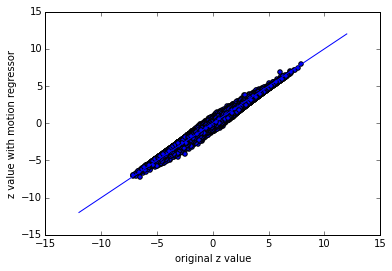

In [26]:
# compare with and without motion regressor
contrast=4
zstat_nomotion=nibabel.load('/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/d78f405a0abb05f3f481f98a941fec93/results/zstat%d.nii.gz'%contrast).get_data()
zstat_motion=nibabel.load('/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/zstat%d.nii.gz'%contrast).get_data()

goodvox=numpy.where(zstat_motion*zstat_nomotion != 0)
plt.scatter(zstat_nomotion[goodvox],zstat_motion[goodvox])
plt.plot([-12,12],[-12,12])
plt.xlabel('original z value')
plt.ylabel('z value with motion regressor')
print numpy.corrcoef(zstat_nomotion[goodvox],zstat_motion[goodvox])

In [31]:
# look at the parameter for the motion regressor
os.system("fslview %s"%filmgls_results.outputs.param_estimates[-1])

0

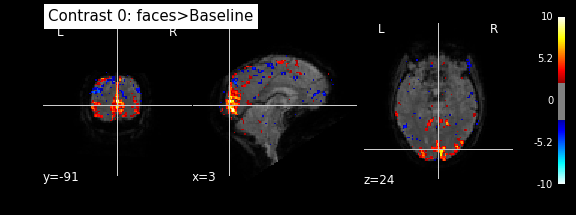

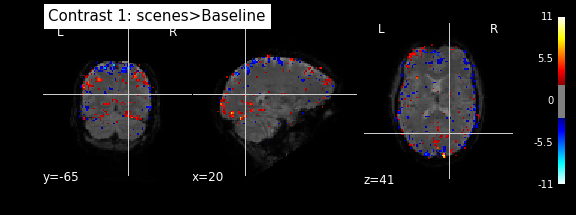

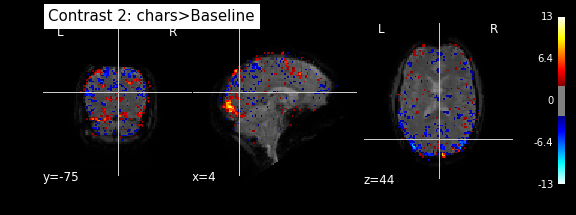

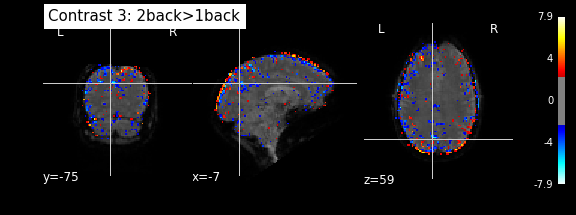

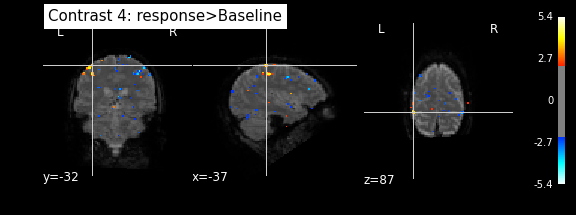

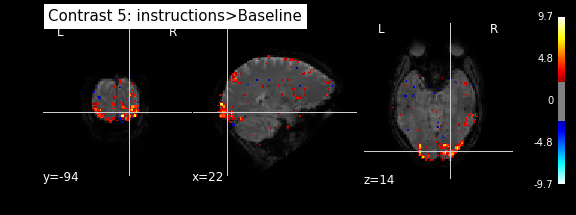

In [11]:
meanimg=nibabel.load(os.path.join(results_dir, "meanbold.nii.gz"))

for contrast_i in range(len(contrasts)):
    nilearn.plotting.plot_stat_map(filmgls_results.outputs.zstats[contrast_i], meanimg,
                                   title='Contrast %d: %s'%(contrast_i,contrasts[contrast_i][0]),
                                   threshold=2.3)

## Move copes, varcopes, and the mask into MNI space

For the group level analysis we need to move results from all subjects into one common MNI space. Let's start with the EPI derived mask (we will use it later for group level mask)

INFO:workflow:Executing node af9e676c611fb1255008b6fe9edc07b4 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/af9e676c611fb1255008b6fe9edc07b4
INFO:workflow:Collecting precomputed outputs
INFO:workflow:Executing node 4c13392ac9e081fea88038572a35efcc in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/4c13392ac9e081fea88038572a35efcc
INFO:workflow:Collecting precomputed outputs


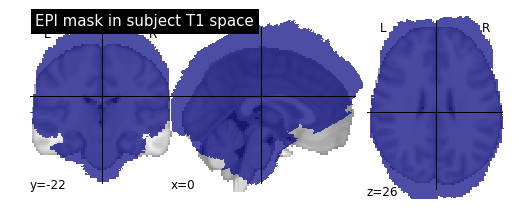

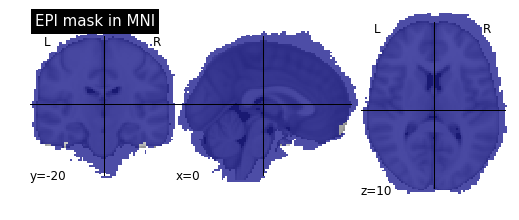

In [12]:
mask_file = os.path.join(results_dir, "mask.nii.gz")
epi_to_t1_warp = os.path.join(results_dir, "epi_to_t1_warp.nii.gz")
t1_to_mni_warp = os.path.join(results_dir, "t1_to_mni_warp.h5")
in_file = mask_file
anat_subject='ses018'
anatomydir=os.path.join(datadir,'ds031/sub00001',anat_subject,
        'anatomy')
t1_file = os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')

epi_to_t1 = mem.cache(fsl.ApplyWarp)
epi_to_t1_mask_results = epi_to_t1(in_file=in_file,
                                   ref_file=t1_file,
                                   field_file=epi_to_t1_warp,
                                   interp="nn")
nilearn.plotting.plot_roi(epi_to_t1_mask_results.outputs.out_file, title="EPI mask in subject T1 space")

t1_to_mni = mem.cache(ants.ApplyTransforms)
t1_to_mni_mask_results = t1_to_mni(input_image=epi_to_t1_mask_results.outputs.out_file,
                                   reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                   transforms=t1_to_mni_warp,
                                   interpolation="NearestNeighbor")
t1_to_mni_mask_results.outputs
nilearn.plotting.plot_roi(t1_to_mni_mask_results.outputs.output_image, title="EPI mask in MNI")

Now we can use the same procedure for all of the contrast and variance images.

INFO:workflow:Executing node 11c5d101e4bed1e6687f2077a6437d7e in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/11c5d101e4bed1e6687f2077a6437d7e
INFO:workflow:Running: applywarp --in=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/842787a644a1643680000baa69bf1550/results/cope1.nii.gz --ref=/home/vagrant/data/ds031/sub00001/ses018/anatomy/sub00001_ses018_T1w_001.nii.gz --out=/home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-fsl-preprocess-ApplyWarp/11c5d101e4bed1e6687f2077a6437d7e/cope1_warp.nii.gz --warp=/home/vagrant/fmri-analysis-vm/analysis/results/epi_to_t1_warp.nii.gz --interp=spline
INFO:workflow:Executing node 676f9bdef78fcba3fb7f9adad5192992 in dir: /home/vagrant/fmri-analysis-vm/analysis/firstlevel/nipype_mem/nipype-interfaces-ants-resampling-ApplyTransforms/676f9bdef78fcba3fb7f9adad5192992
INFO:workflow:Running: antsApplyTransforms --d

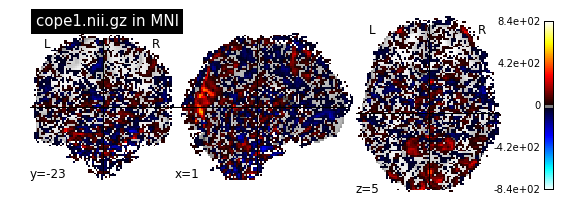

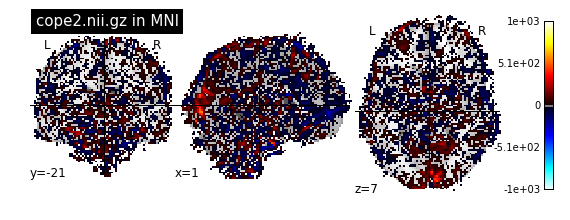

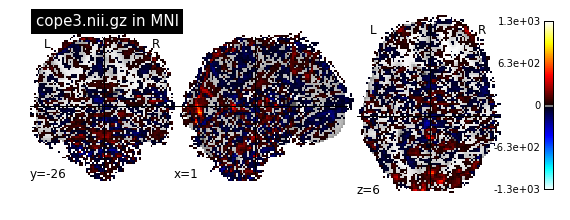

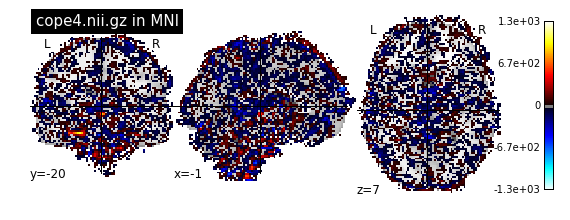

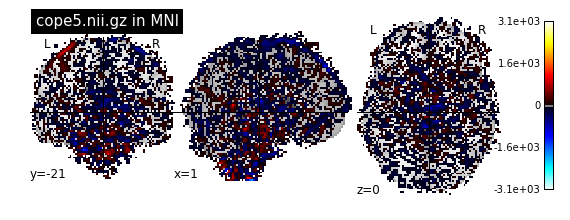

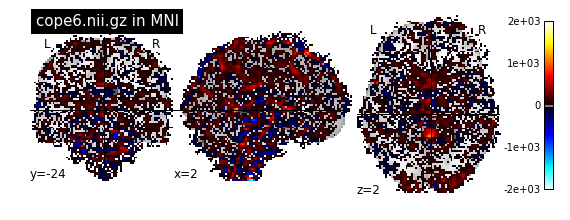

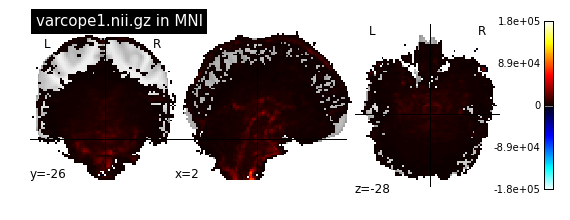

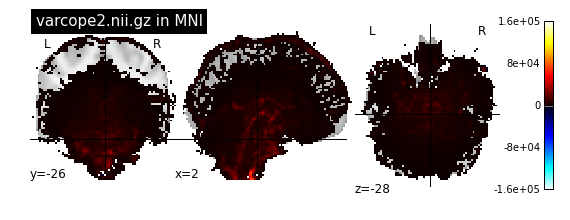

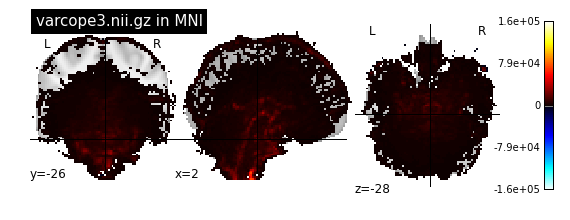

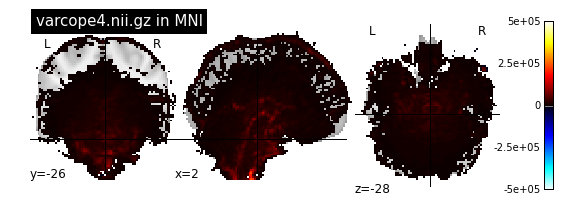

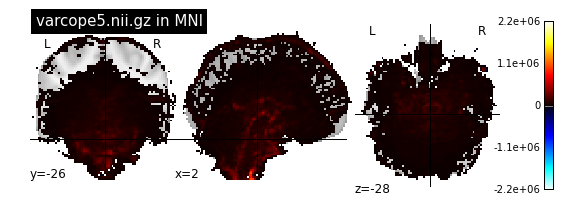

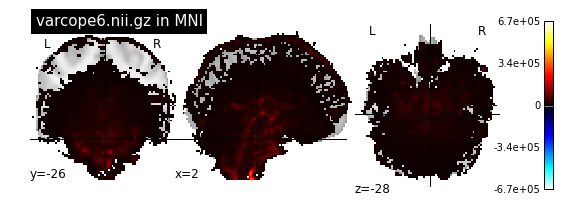

In [13]:
for image in filmgls_results.outputs.copes + filmgls_results.outputs.varcopes:
    _, fname = os.path.split(image)
    epi_to_t1_results = epi_to_t1(in_file=image,
                                       ref_file=t1_file,
                                       field_file=epi_to_t1_warp,
                                       interp="spline")

    t1_to_mni_results = t1_to_mni(input_image=epi_to_t1_results.outputs.out_file,
                                  reference_image=os.path.join(os.getenv('FSLDIR'),'data/standard/MNI152_T1_2mm_brain.nii.gz'),
                                  transforms=t1_to_mni_warp,
                                  interpolation="BSpline")
    nilearn.plotting.plot_stat_map(t1_to_mni_results.outputs.output_image, title="%s in MNI"%fname, threshold='auto')